In [7]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D ,Input , AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import csv
import numpy as np
import time

# Hyperparameters
IMAGE_SIZE = (150,150)
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LEARNING_RATE = 1e-3


def image_gen_w_aug(train_parent_directory, validate_parent_directory, test_parent_directory):
    train_datagen = ImageDataGenerator(
        rescale=1/255,
        rotation_range=20,  # Reduced rotation to 20 degrees
        zoom_range=0.1,     # Reduced zoom range to 10%
        width_shift_range=0.2,  # Reduced shift to 20%
        height_shift_range=0.2, # Reduced shift to 20%
        shear_range=0.1,    # Reduced shear range to 10%
        horizontal_flip=True,
        fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1/255)
    val_datagen = ImageDataGenerator(rescale=1/255)

    train_generator = train_datagen.flow_from_directory(
        train_parent_directory,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        validate_parent_directory,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        test_parent_directory,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    return train_generator, val_generator, test_generator

def model_output():
    model = Sequential()
    
    # First Convolutional Block
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
    model.add(MaxPooling2D(2, 2))
    
    # Second Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Third Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(BatchNormalization())

    # Flatten and Fully Connected Layers
    model.add(Flatten())
 
    model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))

    model.add(Dense(3, activation='softmax',kernel_regularizer=l2(0.001)))


    return model

train_dir = os.path.join('./datasets/train')
test_dir = os.path.join('./datasets/test')
val_dir = os.path.join('./datasets/validation')

train_generator, validation_generator, test_generator = image_gen_w_aug(train_dir, val_dir, test_dir)

model = model_output()
model.compile(
    optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Learning rate reduction
early_stop= EarlyStopping(monitor='val_loss',patience=7,verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Start time
start_time = time.time()

model.summary()

with tf.device("/GPU:0"):
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        verbose=1,
        validation_data=validation_generator,
        callbacks=[lr_scheduler,early_stop]
    )


# end Time
end_time = time.time()
# duration 
duration = end_time - start_time

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

tf.keras.models.save_model(model,'my_model.h5')



Found 2400 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 909,347 (3.47 MB)

 Trainable params: 909,091 (3.47 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 340ms/step - accuracy: 0.4524 - loss: 1.4762 - val_accuracy: 0.4600 - val_loss: 1.3312 - learning_rate: 0.0010
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 52s 337ms/step - accuracy: 0.6941 - loss: 1.0144 - val_accuracy: 0.6100 - val_loss: 1.1602 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 345ms/step - accuracy: 0.7175 - loss: 0.9132 - val_accuracy: 0.7900 - val_loss: 0.8708 - learning_rate: 0.0010
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 52s 333ms/step - accuracy: 0.7573 - loss: 0.8340 - val_accuracy: 0.6833 - val_loss: 0.9370 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 53s 338ms/step - accuracy: 0.7716 - loss: 0.7905 - val_accuracy: 0.7300 - val_loss: 0.7242 - learning_rate: 0.0010
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 53s 340ms/step - accuracy: 0.7760 - loss: 0.7374 - val_accuracy: 0.7933 - val_loss: 0.6477 - learning_rate: 0.0010
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 53s 338ms/step - accura

filter to original 128 and 64 with batchnorm

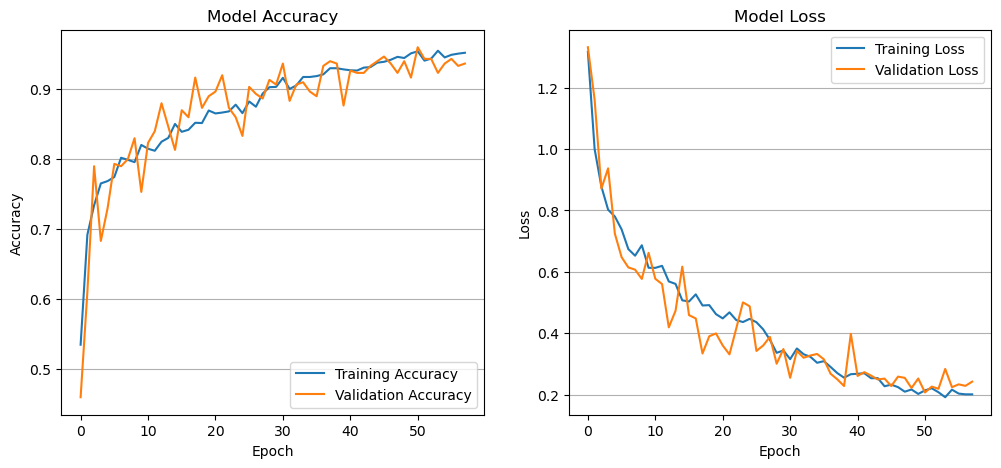

Total time taken to train the model: 51 minutes and 36 seconds

Final Training Accuracy: 0.9521
Final Validation Accuracy: 0.9367

Final Training Loss: 0.2012
Final Validation Loss: 0.2426

Test Accuracy: 92.00%
Test Loss: 0.3030


In [9]:

# Plot training and validation accuracy
plt.figure(figsize=(12,5))       
plt.subplot(121)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Model Accuracy")
plt.grid(axis='y')
plt.legend()

# Plot training and validation loss
plt.subplot(122)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Model Loss")
plt.legend()
plt.grid(axis='y')
plt.show()

# Convert duration to minutes and seconds
duration_min, duration_sec = divmod(duration, 60)
print(f'Total time taken to train the model: {int(duration_min)} minutes and {int(duration_sec)} seconds')
print()
# Print out the final accuracy values
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print()
# Print out the final loss values
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print()
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')